# Prediction stock returns with linear regression


## Imports & Settings


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style("whitegrid")
idx = pd.IndexSlice

In [4]:
YEAR = 252

## Load Data


In [5]:
with pd.HDFStore("data.h5") as store:
    data = store["model_data"].dropna().drop(["open", "close", "low", "high"], axis=1)

In [6]:
data.index.names = ["symbol", "date"]

In [7]:
data = data.drop([c for c in data.columns if "lag" in c], axis=1)

### Select Investment Universe


In [8]:
data = data[data["dollar_vol_rank"] < 100]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

### Create Model Data


In [10]:
y = data.filter(like="target")
X = data.drop(y.columns, axis=1)
X = X.drop(["dollar_vol", "dollar_vol_rank", "volume", "consumer_durables"], axis=1)

## Custom MultipleTimeSeriesCV


In [11]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=None,
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X: pd.DataFrame, y=None, groups=None):
        unique_dates = X.index.get_level_values("date").unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + +self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[["date"]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates["date"] > days[train_start]) & (dates["date"] <= days[train_end])
            ].index
            test_idx = dates[
                (dates["date"] > days[test_start]) & (dates["date"] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Verify that it works


In [12]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

In [13]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values("date")
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values("date")
    df = pd.concat([train.reset_index(), test.reset_index()])
    n = len(df)
    assert n == len(df.drop_duplicates())
    print(
        train.groupby(level="symbol").size().value_counts().index[0],
        train_dates.min().date(),
        train_dates.max().date(),
        test.groupby(level="symbol").size().value_counts().index[0],
        test_dates.min().date(),
        test_dates.max().date(),
    )
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


## Visualization helper functions


### Prediction vs Actual Scatter Plot


In [14]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(
        x="predicted",
        y="actuals",
        robust=True,
        ci=None,
        line_kws={"lw": 1, "color": "k"},
        scatter_kws={"s": 1},
        data=df,
        kind="reg",
    )
    j.ax_joint.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.1%}".format(y)))
    j.ax_joint.xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.1%}".format(x)))
    j.ax_joint.set_xlabel("Predicted")
    j.ax_joint.set_ylabel("Actuals")

### Daily IC Distribution


In [15]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df["ic"], ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df["ic"].mean(), df["ic"].median()
    ax.axvline(0, lw=1, ls="--", c="k")
    ax.text(
        x=0.05,
        y=0.9,
        s=f"Mean: {mean:8.2f}\nMedian: {median:5.2f}",
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
    )
    ax.set_xlabel("Information Coefficient")
    sns.despine()
    plt.tight_layout()

### Rolling Daily IC


In [16]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df["ic"].mean()
    rolling_result["ic"].plot(
        ax=axes[0], title=f"Information Coefficient (Mean: {mean_ic:.2f})", lw=1
    )
    axes[0].axhline(0, lw=0.5, ls="-", color="k")
    axes[0].axhline(mean_ic, lw=1, ls="--", color="k")

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(
        ax=axes[1],
        title=f"Root Mean Squared Error (Mean: {mean_rmse:.2%})",
        lw=1,
        ylim=(0, df.rmse.max()),
    )
    axes[1].axhline(df.rmse.mean(), lw=1, ls="--", color="k")
    sns.despine()
    plt.tight_layout()

## Linear Regression with sklearn


### Set up cross-validation


In [17]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

### Run cross-validation with LinearRegression


In [18]:
target = f"target_{lookahead}d"
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    (
        X_train,
        y_train,
    ) = (
        X.iloc[train_idx],
        y[target].iloc[train_idx],
    )
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame("actuals").assign(predicted=y_pred)
    preds_by_day = preds.groupby(level="date")
    scores = pd.concat(
        [
            preds_by_day.apply(
                lambda x: spearmanr(x.predicted, x.actuals)[0] * 100
            ).to_frame("ic"),
            preds_by_day.apply(
                lambda x: np.sqrt(
                    mean_squared_error(y_pred=x.predicted, y_true=x.actuals)
                )
            ).to_frame("rmse"),
        ],
        axis=1,
    )

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

### Persist results


In [19]:
lr_scores.to_hdf("data.h5", "lr/scores")
lr_predictions.to_hdf("data.h5", "lr/predictions")

In [20]:
lr_scores = pd.read_hdf("data.h5", "lr/scores")
lr_predictions = pd.read_hdf("data.h5", "lr/predictions")

### Evaluate results


In [21]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f"Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})")

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


#### Prediction vs Actuals Scatter


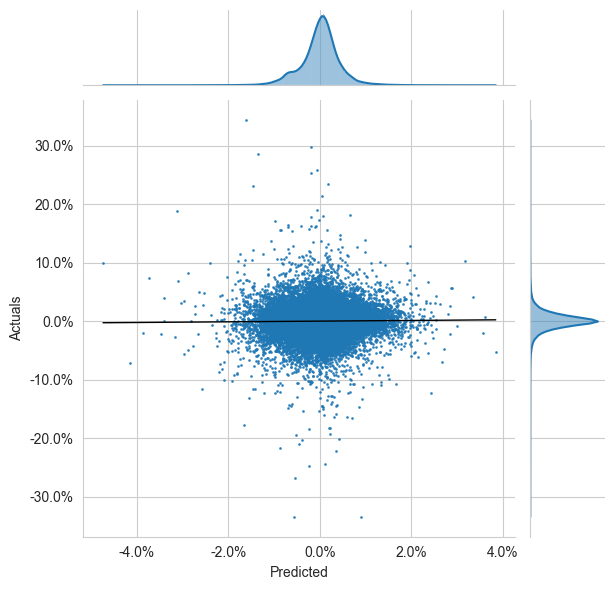

In [22]:
plot_preds_scatter(lr_predictions)
plt.show()

#### Daily IC Distribution


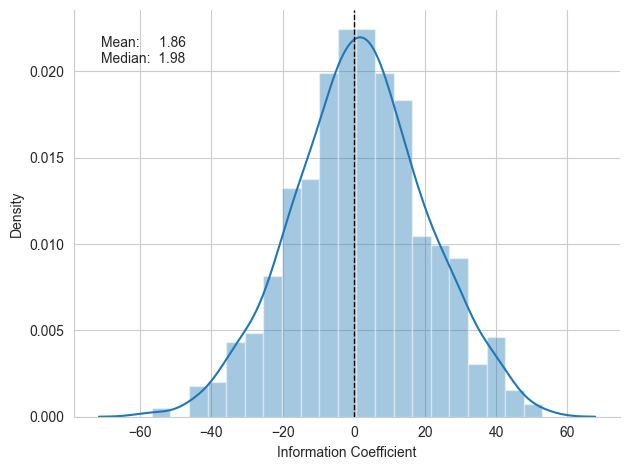

In [23]:
plot_ic_distribution(lr_scores)
plt.show()

#### Rolling Daily IC


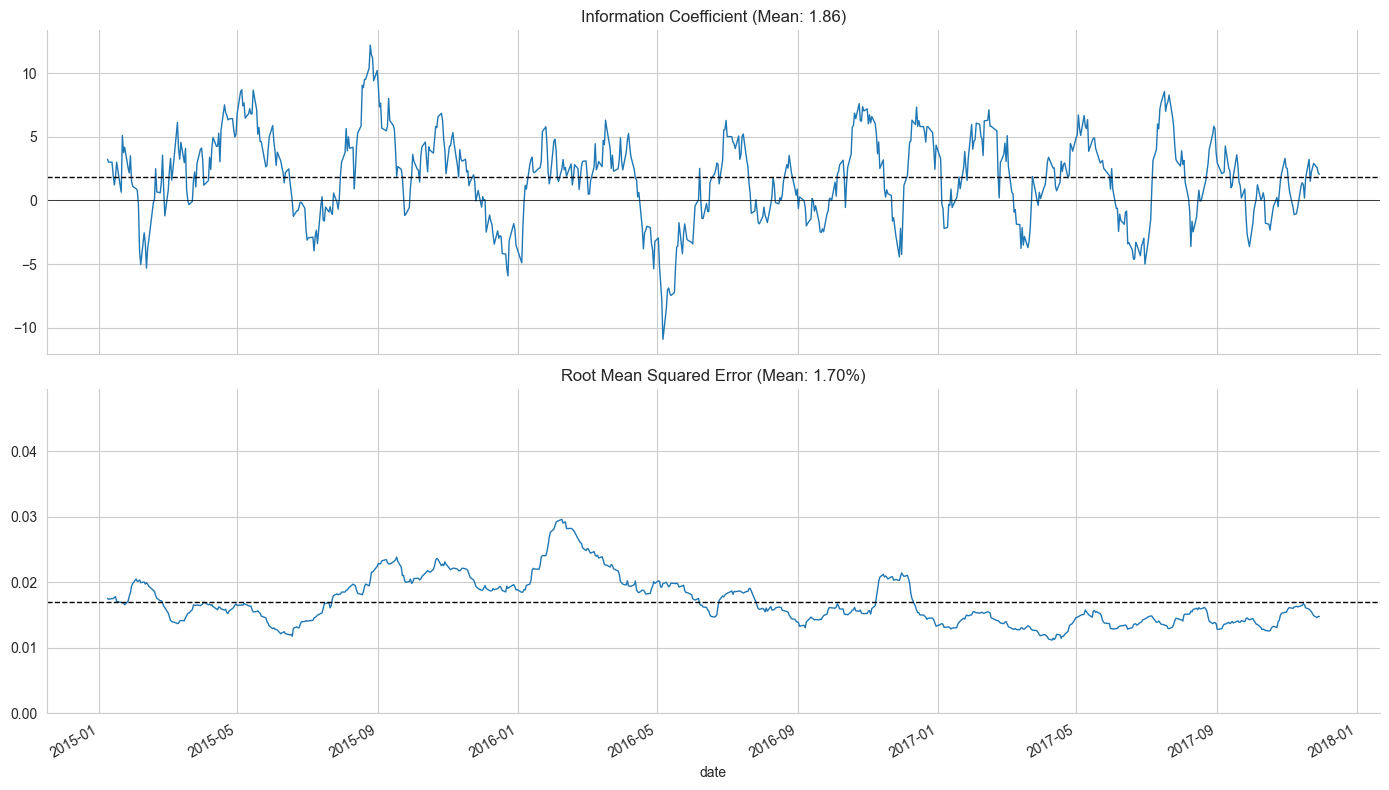

In [24]:
plot_rolling_ic(lr_scores)
plt.show()

## Ridge Regression


### Define cross-validation parameters


In [25]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [26]:
n_splits = int(3 * YEAR / test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

### Run cross-validation


In [27]:
target = f"target_{lookahead}d"

X = X.drop([c for c in X.columns if "year" in c], axis=1)

In [28]:
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=" ", flush=True)
    model = Ridge(alpha=alpha, fit_intercept=False, random_state=42)

    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        (
            X_train,
            y_train,
        ) = (
            X.iloc[train_idx],
            y[target].iloc[train_idx],
        )
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame("actuals").assign(predicted=y_pred)
        preds_by_day = preds.groupby(level="date")
        scores = pd.concat(
            [
                preds_by_day.apply(
                    lambda x: spearmanr(x.predicted, x.actuals)[0] * 100
                ).to_frame("ic"),
                preds_by_day.apply(
                    lambda x: np.sqrt(
                        mean_squared_error(y_pred=x.predicted, y_true=x.actuals)
                    )
                ).to_frame("rmse"),
            ],
            axis=1,
        )

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps["model"].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print("\n")

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 



### Persist results


In [29]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf("data.h5", "ridge/scores")

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf("data.h5", "ridge/coeffs")

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf("data.h5", "ridge/predictions")

In [30]:
ridge_scores = pd.read_hdf("data.h5", "ridge/scores")
ridge_coeffs = pd.read_hdf("data.h5", "ridge/coeffs")
ridge_predictions = pd.read_hdf("data.h5", "ridge/predictions")

### Evaluate Ridge Results


In [31]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f"Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})")

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


In [32]:
ridge_scores.groupby("alpha")["ic"].describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


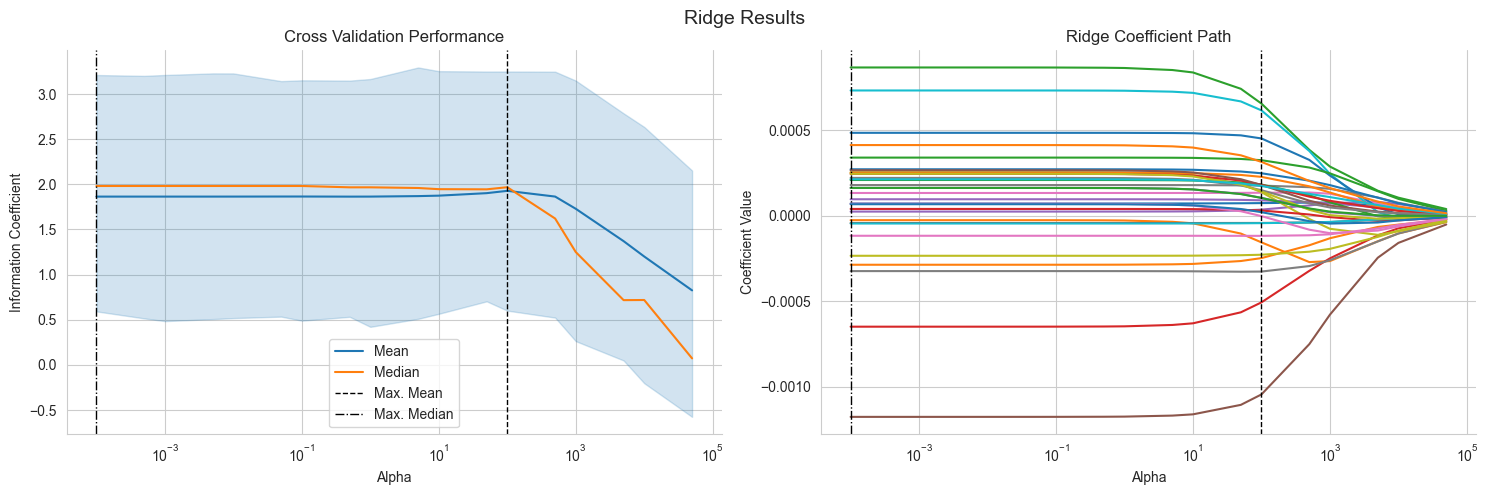

In [33]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby("alpha").ic.agg(["mean", "median"])
best_alpha_mean = scores_by_alpha["mean"].idxmax()
best_alpha_median = scores_by_alpha["median"].idxmax()

ax = sns.lineplot(
    x="alpha", y="ic", data=ridge_scores, estimator=np.mean, label="Mean", ax=axes[0]
)

scores_by_alpha["median"].plot(logx=True, ax=axes[0], label="Median")

axes[0].axvline(best_alpha_mean, ls="--", c="k", lw=1, label="Max. Mean")
axes[0].axvline(best_alpha_median, ls="-.", c="k", lw=1, label="Max. Median")
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Information Coefficient")
axes[0].set_title("Cross Validation Performance")

ridge_coeffs.plot(logx=True, legend=False, ax=axes[1], title="Ridge Coefficient Path")

axes[1].axvline(best_alpha_mean, ls="--", c="k", lw=1, label="Max. Mean")
axes[1].axvline(best_alpha_median, ls="-.", c="k", lw=1, label="Max. Median")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("Coefficient Value")

fig.suptitle("Ridge Results", fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

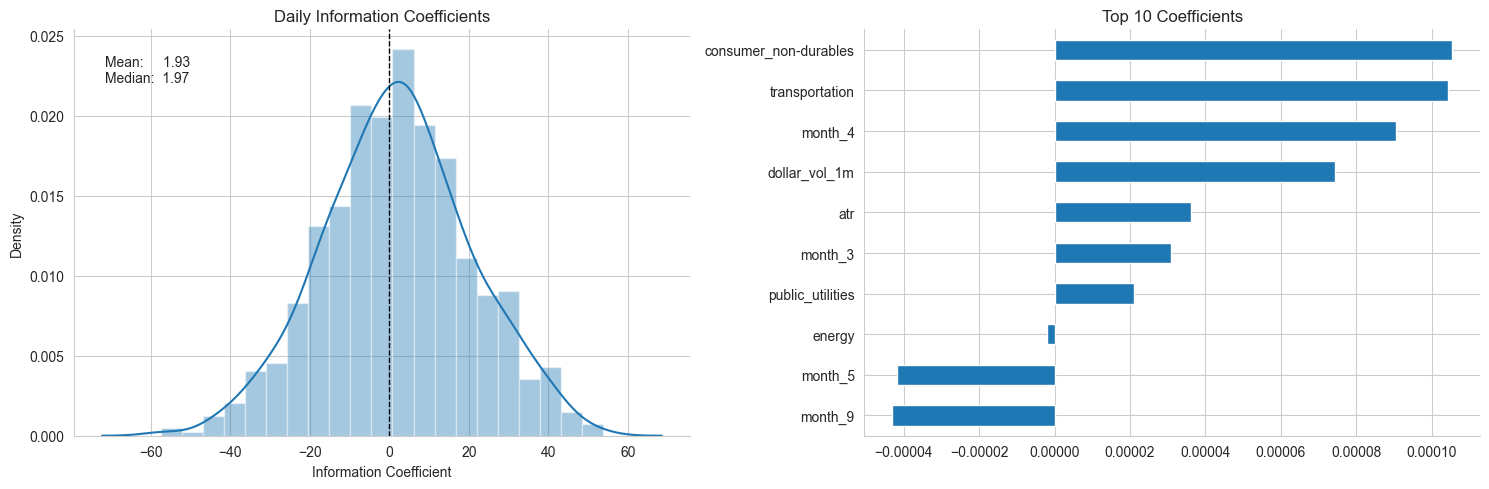

In [34]:
best_alpha = ridge_scores.groupby("alpha").ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha], ax=axes[0])
axes[0].set_title("Daily Information Coefficients")
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(
    ax=axes[1], title="Top 10 Coefficients"
)
sns.despine()
fig.tight_layout()
plt.show()

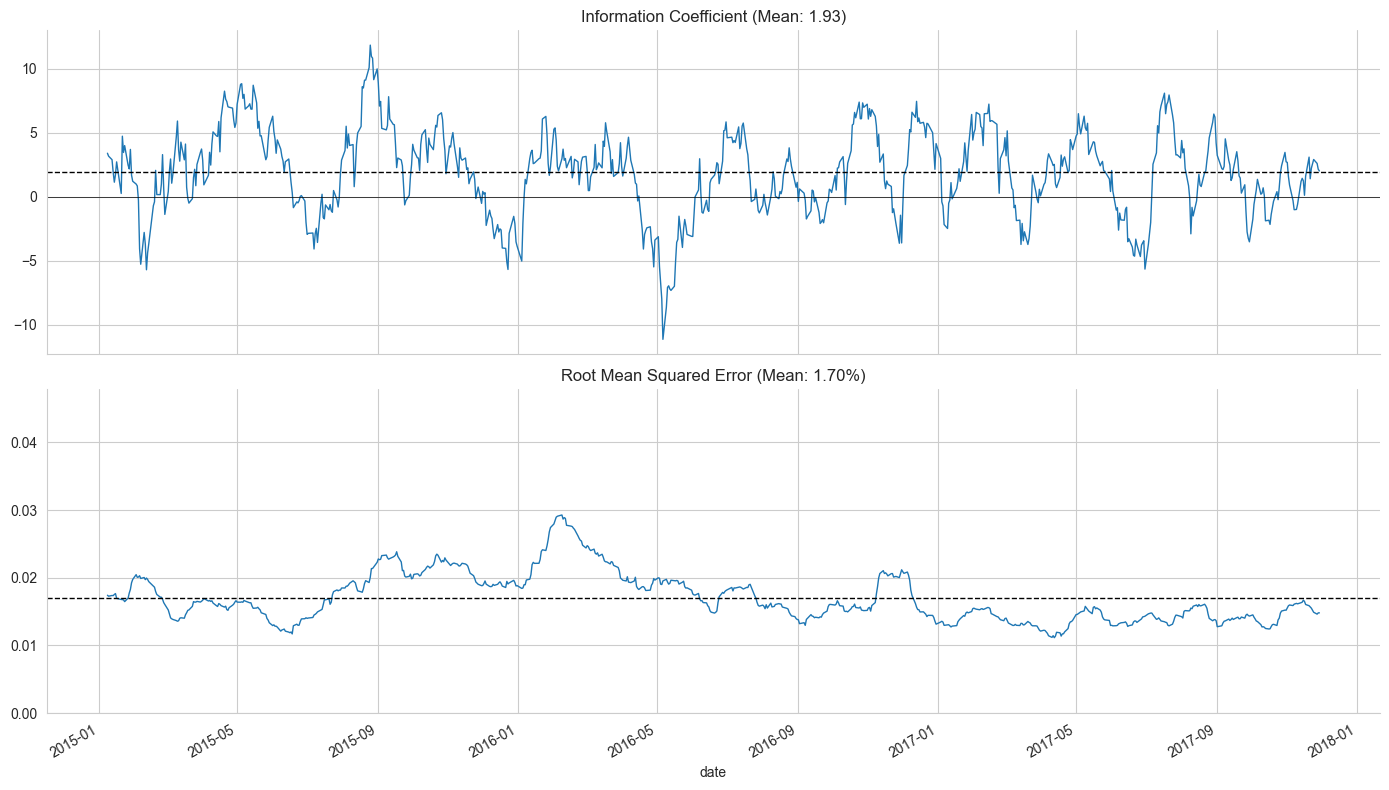

In [35]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha == best_alpha])
plt.show()

## Lasso CV


### Define cross-validation parameters


In [36]:
lasso_alphas = np.logspace(-10, -3, 8)

In [37]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length)  # three years
lookahead = 1

In [38]:
cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

### Run cross-validation with Lasso regression


In [39]:
target = f"target_{lookahead}d"

scaler = StandardScaler()
X = X.drop([c for c in X.columns if "year" in c], axis=1)

In [51]:
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=" ", flush=True)
    model = Lasso(
        alpha=alpha,
        fit_intercept=False,  # StandardScaler centers data
        random_state=42,
        tol=1e-3,
        max_iter=1000,
        warm_start=True,
        selection="random",
    )

    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        (
            X_train,
            y_train,
        ) = (
            X.iloc[train_idx],
            y[target].iloc[train_idx],
        )
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame("actuals").assign(predicted=y_pred)
        preds_by_day = preds.groupby(level="date")
        scores = pd.concat(
            [
                preds_by_day.apply(
                    lambda x: spearmanr(x.predicted, x.actuals)[0] * 100
                ).to_frame("ic"),
                preds_by_day.apply(
                    lambda x: np.sqrt(
                        mean_squared_error(y_pred=x.predicted, y_true=x.actuals)
                    )
                ).to_frame("rmse"),
            ],
            axis=1,
        )

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps["model"].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 

### Persist results


In [52]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf("data.h5", "lasso/scores")

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf("data.h5", "lasso/coeffs")

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf("data.h5", "lasso/predictions")

### Evaluate Lasso Results


In [53]:
best_alpha = lasso_scores.groupby("alpha")["ic"].mean().idxmax()
preds = lasso_predictions[lasso_predictions["alpha"] == best_alpha]

lasso_r, lasso_p = spearmanr(preds["actuals"], preds["predicted"])
print(f"Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})")

Information Coefficient (overall): 3.595% (p-value: 0.0000%)


In [54]:
lasso_scores.groupby("alpha").ic.agg(["mean", "median"])

,mean,median
alpha,,
1.000000e-10,1.863889,1.981447
1.000000e-09,1.863758,1.981447
1.000000e-08,1.864487,1.981447
1.000000e-07,1.865393,1.966605
1.000000e-06,1.875294,1.962276
1.000000e-05,1.935876,2.191108
1.000000e-04,1.575376,1.012989
1.000000e-03,1.025462,1.768092


### Lasso Coefficient Path


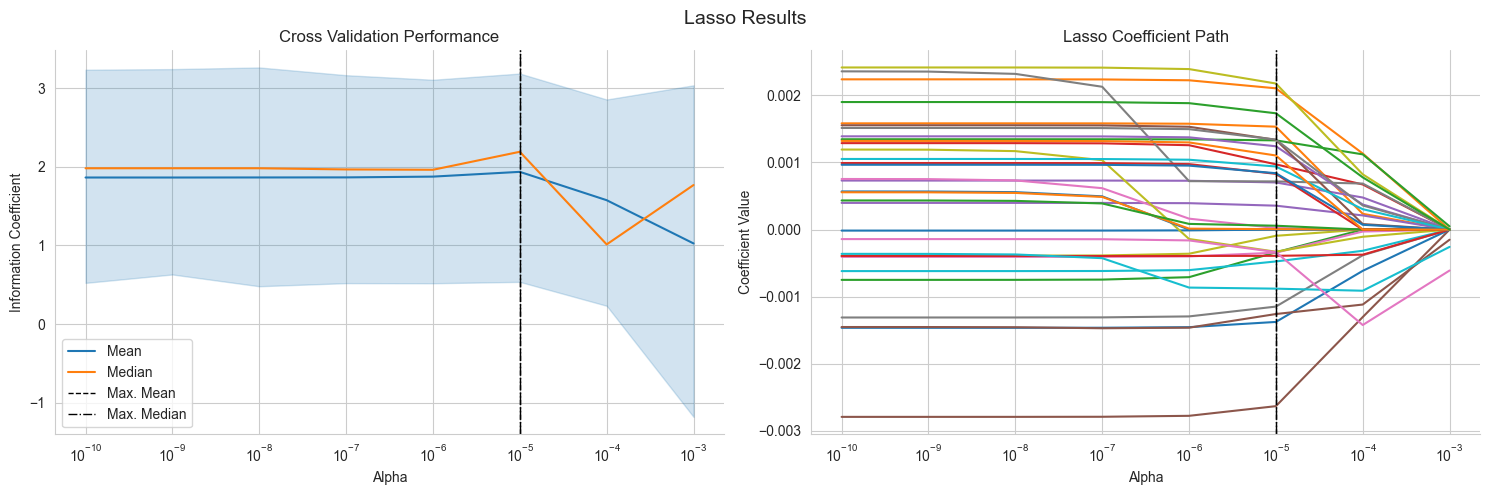

In [65]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby("alpha").ic.agg(["mean", "median"])
best_alpha_mean = scores_by_alpha["mean"].idxmax()
best_alpha_median = scores_by_alpha["median"].idxmax()

ax = sns.lineplot(
    x="alpha",
    y="ic",
    data=lasso_scores.dropna(),
    estimator=np.mean,
    label="Mean",
    ax=axes[0],
)

scores_by_alpha["median"].plot(logx=True, ax=axes[0], label="Median")

axes[0].axvline(best_alpha_mean, ls="--", c="k", lw=1, label="Max. Mean")
axes[0].axvline(best_alpha_median, ls="-.", c="k", lw=1, label="Max. Median")
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Information Coefficient")
axes[0].set_title("Cross Validation Performance")

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title="Lasso Coefficient Path")
axes[1].axvline(best_alpha_mean, ls="--", c="k", lw=1, label="Max. Mean")
axes[1].axvline(best_alpha_median, ls="-.", c="k", lw=1, label="Max. Median")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("Coefficient Value")

fig.suptitle("Lasso Results", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
sns.despine()
plt.show()

### Lasso IC Distribution and Top 10 Features


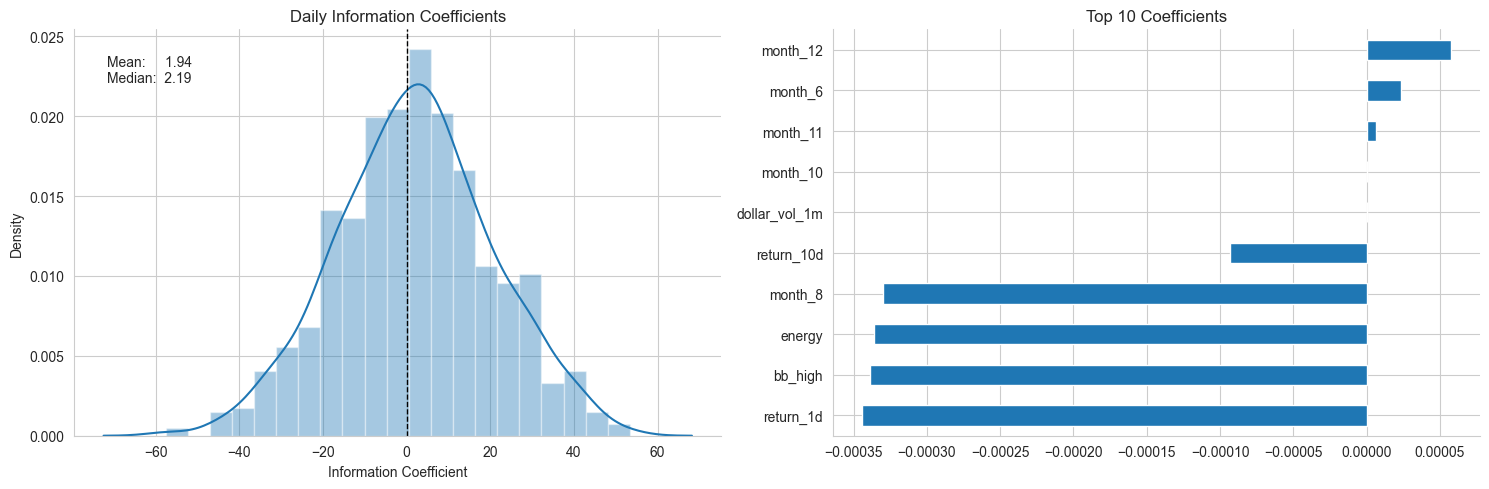

In [66]:
best_alpha = lasso_scores.groupby("alpha").ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha == best_alpha], ax=axes[0])
axes[0].set_title("Daily Information Coefficients")

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(
    ax=axes[1], title="Top 10 Coefficients"
)

sns.despine()
fig.tight_layout()
plt.show()

## Compare results


In [67]:
best_ridge_alpha = ridge_scores.groupby("alpha").ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha == best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha == best_ridge_alpha]

In [68]:
best_lasso_alpha = lasso_scores.groupby("alpha").ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha == best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha == best_lasso_alpha]

In [69]:
df = pd.concat(
    [
        lr_scores.assign(Model="Linear Regression"),
        best_ridge_scores.assign(Model="Ridge Regression"),
        best_lasso_scores.assign(Model="Lasso Regression"),
    ]
).drop("alpha", axis=1)
df.columns = ["IC", "RMSE", "Model"]

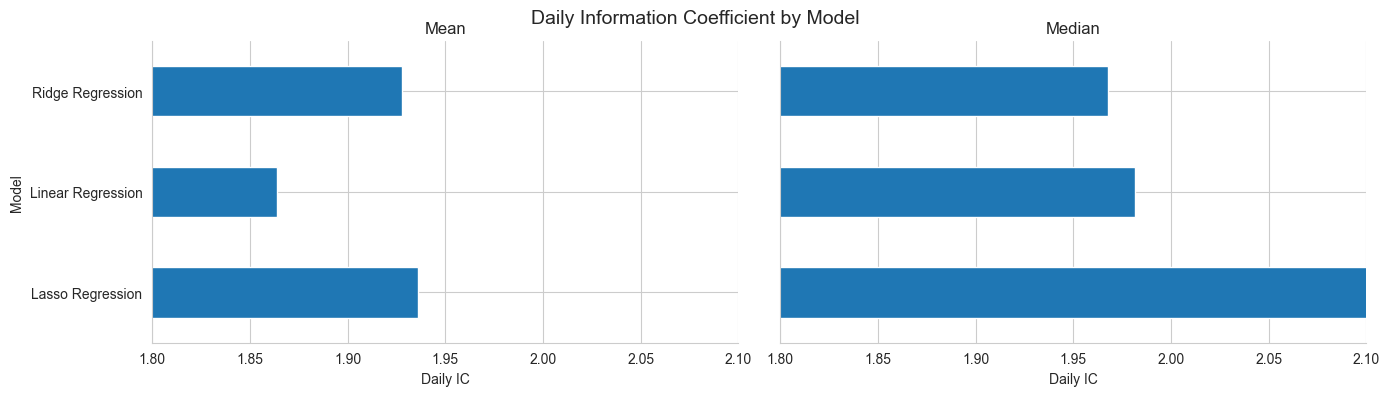

In [70]:
scores = df.groupby("Model").IC.agg(["mean", "median"])
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True, sharex=True)

scores["mean"].plot.barh(ax=axes[0], xlim=(1.85, 2), title="Mean")
scores["median"].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title="Median")
axes[0].set_xlabel("Daily IC")
axes[1].set_xlabel("Daily IC")

fig.suptitle("Daily Information Coefficient by Model", fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()